<center><h1>VC03: Clustering Jerárquico Divisivo</h1></center>

En esta práctica estudiaremos el funcionamiento y la utilización del clústering jerárquico divisivo.

Para empezar, cargamos las librerías que vamos a necesitar:

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree


Para comenzar, cargamos el conjunto de datos con el que trabajaremos:


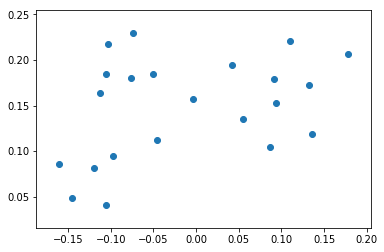

In [2]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_reducido.csv'
Dx = np.array(pd.read_csv(data_file_url,header=0))
Dx = Dx[ np.random.choice(np.arange(Dx.shape[0]), Dx.shape[0], replace=False) ,:]

plt.scatter(Dx[:,0], Dx[:,1])
plt.show()


Es el mismo dataset que usamos en la práctica anterior. Lo volveremos a usar ahora para estudiar las diferentes variantes del clústering divisivo. Empezamos nuevamente calculando la matriz de distancias, para lo que necesitaremos  la función matriz_distancias desarrollada en prácticas anteriores.  


In [3]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD


Necesitamos una función que, dada una matriz de distancias, construya un clustering divisivo. Es decir, partiendo de un único clúster (con todos los ejemplos de entrenamiento), se van dividiendo en dos iterativamente hasta que finalmente todos los elementos tienen su propio clúster unitario. En cada paso, el clúster a dividir se escoge como aquél que maximiza la disimilitud intraclúster (que puede ser definida de acuerdo a diferentes criterios). El clúster escogido se divide de acuerdo a cierto procedimiento de separación.

Sabemos que el número de divisiones es igual a n-1 (el número de ejemplos menos uno). En la siguiente función, vamos guardando en cada columna de la matriz mParticiones la partición en clústeres de los ejemplos: cada partición mParticiones[:,p], de longitud n, guarda el clúster al que pertenece el i-ésimo ejemplo en la posición mParticiones[i,p]. Para rellenar esa matriz, en cada paso (división), se calcula la disimilitud intraclúster de todos los clústeres usando el criterio elegido y se elige un clúster a dividir (iClusterADiv). Después, se aplica el procedimiento de separación elegido para obtener un subconjunto de elementos de ese clúster que pasan a formar parte de un nuevo clúster (se les asigna al clúster con índice n). Este procedimiento iterativo se repite hasta que sólo quedan clústeres unitarios (cada clúster tiene un único elemento) en el paso final:


In [4]:
def clustering_divisivo(mD, disimilitud_intracluster, separador, **kwargs):
    mParticiones = np.zeros(mD.shape[0]**2,dtype=np.int8)
    mParticiones.shape = (mD.shape[0],Dx.shape[0])

    for n in (np.arange(mD.shape[0]-1)+1):
        mParticiones[:,n] = mParticiones[:,n-1]

        # calcular la disimilitud intracluster
        # y elegir el que tenga mas
        rDisIntraCluster = disimilitud_intracluster(mD, mParticiones[:,n], n)
        iClusterADiv = np.argmax(rDisIntraCluster) #### TU CODIGO AQUI ####
        
        iAClusterNuevo = separador(mD, mParticiones[:,n], iClusterADiv, **kwargs)

        mParticiones[iAClusterNuevo,n] = n
    return mParticiones


Como se comentaba anteriormente, la primera decisión a tomar es qué clúster se va a dividir. Para ello se evalúa la disimilitud intraclúster. Hay diferentes maneras de medir dicha disimilitud. Una de ellas es mediante el <b>diámetro</b> del clúster, que se define como la máxima distancia entre dos elementos cualquiera del clúster. La siguiente función calcula dicho valor (diámetro) para todos los clústeres y los devuelve en un array:


In [5]:
def disimilitud_diametro(mD, particion, n):
    res = [ np.max((mD[ np.ix_(particion == pn , particion == pn #### TU CODIGO AQUI ####
                              ) ] +
                    np.transpose(mD[ np.ix_(particion == pn , particion == pn) ]))/ 2)
           for pn in np.arange(n)]
    return res


Otra manera de calcular la disimilitud intraclúster es usando la <b>disimilitud media</b> del clúster, que se define como la distancia media entre todos los pares de elementos del clúster. La siguiente función calcula dicha disimilitud para todos los clústeres y los devuelve en un array: 


In [6]:
def disimilitud_media(mD, particion, n):
    #### TU CODIGO AQUI ####
    res = [np.sum(mD[ np.ix_(particion == pn , particion == pn) ]) / (np.sum(particion == pn)**2)
           if np.sum(particion == pn) != 0 else 0 for pn in np.arange(n)]
    return res


Una vez identificado el clúster que queremos dividir, el siguiente objetivo es saber cómo lo vamos a dividir. Para ello, se pueden aplicar también diferentes procedimientos.

El procedimiento propuesto por Macnaughton y Smith consiste en identificar, inicialmente, el ejemplo del clúster con mayor diferencia media con respecto al resto de elementos del clúster. Éste será el primer ejemplo que se separa del clúster. A partir se ese momento, de manera iterativa, se van separando nuevos elementos del primer clúster (original) y se incluyen en el nuevo grupo. En cada paso, el ejemplo que se traspasa es aquel que tiene menor distancia media con los elementos del nuevo clúster con respecto a la distancia media con los otros elementos que todavía están en el clúster original. Este traspaso se repite hasta que no haya ningún elemento en el clúster original que esté más cerca (en media) a los elementos del otro clúster que a los del suyo propio.


In [7]:
def separacion_macnaughton_smith(mDglobal, particion, iCluster):
    indsClust = np.where(particion==iCluster)[0]
    mD = mDglobal[ np.ix_(indsClust , indsClust)]
    
    SA = np.array([np.argmax(1/((mD.shape[0]-1)*2)*(np.sum(mD,axis=0)+np.sum(mD,axis=1)))])
    SB = np.delete(np.arange(mD.shape[0]), SA)
    if (SB.size == 1):
        return indsClust[SA]

    while True:
        res = np.zeros(SB.size)
        # Para todos los elementos del cluster original SB
        for i in np.arange(SB.size):
            SBa = np.delete(SB,i) 
            
            res[i] = (# distancia media con los otros elementos de SB
                np.sum(mD[ SB[i] , SBa ]) + np.sum(mD[ SBa , SB[i] ])
                #### TU CODIGO AQUI ####
            ) / (2 * SBa.size) - (# distancia media con los elementos ya movidos a SA
                np.sum(mD[ SB[i] , SA ]) + np.sum(mD[ SA , SB[i] ])
                #### TU CODIGO AQUI ####
            ) / (2 * SA.size)


        # Si en todos los casos la distancia es negativa quiere decir que 
        # no existe ningún elemento en SB más cercano a SA que al resto de SB
        if all(map(lambda x : x < 0, res)):#### TU CODIGO AQUI ####:
            break

        iToChange = np.argmax(res)
        SA = np.sort(np.append(SA, SB[iToChange]))
        SB = np.delete(np.arange(mD.shape[0]), SA)
    
    # Devolveremos los índices de los elementos que pertenecerán 
    # al clúster SA
    return indsClust[SA] #### TU CODIGO AQUI ####


Otra manera de realizar la separación del clúster en dos es mediante el algoritmo K-means con K=2. Así se obtienen dos clústeres (a partir del clúster original) de manera rápida y utilizando éste popular algoritmo.


In [8]:
def separacion_Kmeans(mDglobal, particion, iCluster, Dxglobal):
    indsClust = np.where(particion==iCluster)[0]
    Dx = Dxglobal[indsClust,:]
    
    modelo = KMeans(n_clusters=2) #### TU CODIGO AQUI ####)
    modelo = modelo.fit(Dx)
    Dyp = modelo.predict(Dx)

    # Devolveremos los índices de los ejemplos asignados 
    # al segundo clúster
    return indsClust[np.where(Dyp==1)[0]] #### TU CODIGO AQUI ####


Finalmente, incluimos las funciones que nos permiten visualizar los resultados:


In [9]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
    cmap = get_cmap('tab20')
    vals = np.arange(Dx.shape[0]+2)/(Dx.shape[0]+2)
    rgba = cmap(vals[np.arange(Dx.shape[0])+1])

    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(Dx[:,0],Dx[:,1], c=rgba[mParticiones[:,K-1],:])

# Muestra el plot de todas las particiones posibles de la jerarquía
def plot_particiones(Dx, mParticiones):
    for k in np.arange(mParticiones.shape[1]):
        plot_particion_K(Dx, mParticiones,k+1)

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (    
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(25, 10))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()


Ahora ya estamos en disposición de realizar el clustering jerárquico divisivo. Empezaremos por calcular la matriz de distancias y, por este orden, calcularemos y mostraremos el dendrograma de los diferentes agrupamientos obtenidos de usar el criterio de disimilitud media y diámetro, en combinación con la separación de Macnaughton-Smith y la de K-means. También mostraremos (plotear) las respectivas particiones con 5 clústeres: 


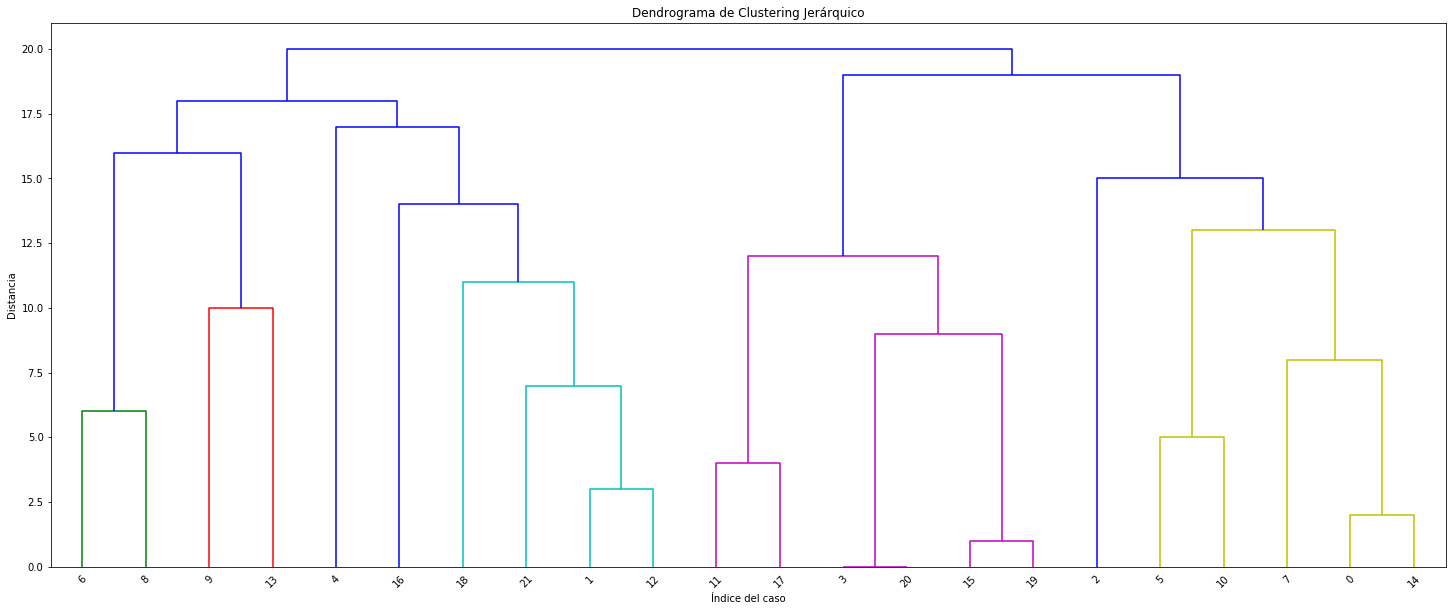

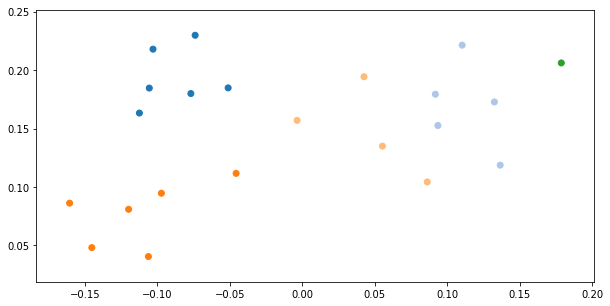

In [10]:
mD = matriz_distancias(Dx, distancia_euclidiana)
K = 5 # parametro para mostrar una particion

# Usando disimilitud media y el método de separacion de Macnaughton-Smith
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_macnaughton_smith)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

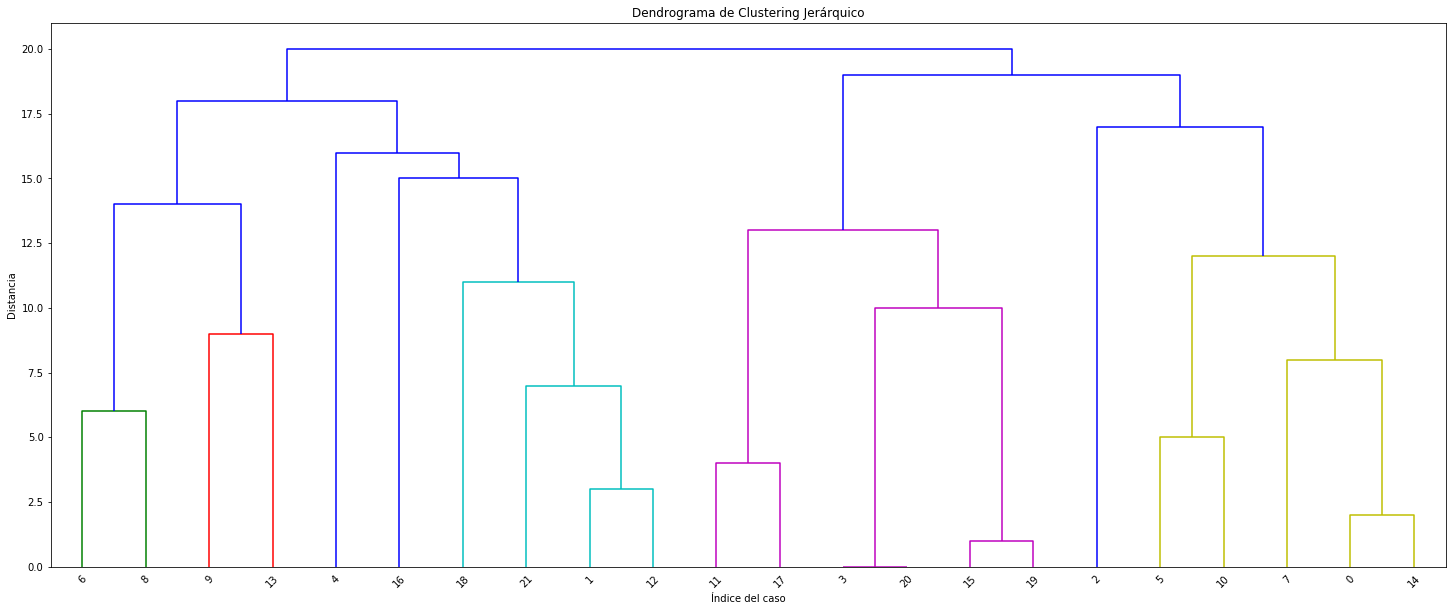

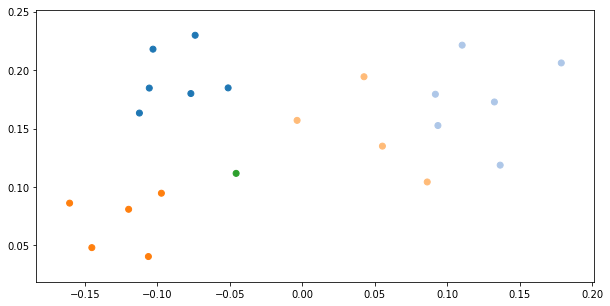

In [11]:
# Usando disimilitud diámetro y el método de separacion de Macnaughton-Smith
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_macnaughton_smith)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

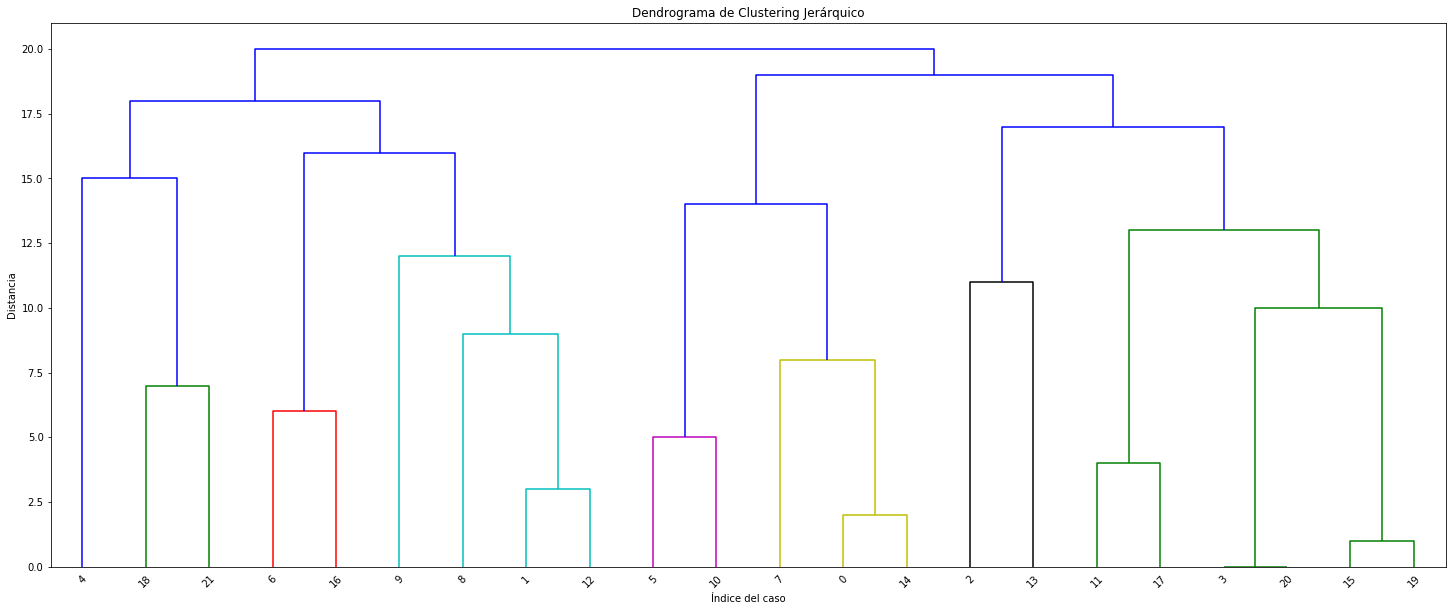

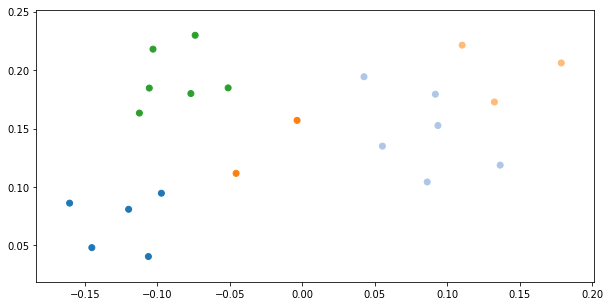

In [12]:
# Usando disimilitud media y K-means como método de separacion
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_Kmeans, Dxglobal=Dx)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

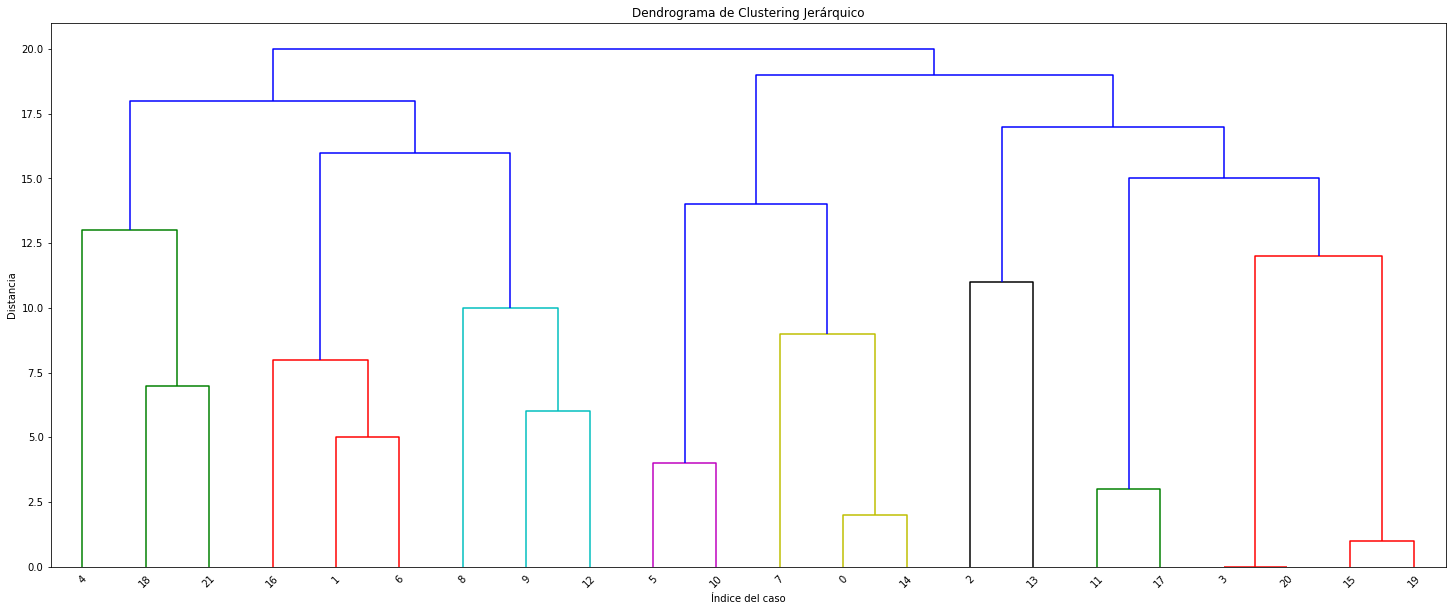

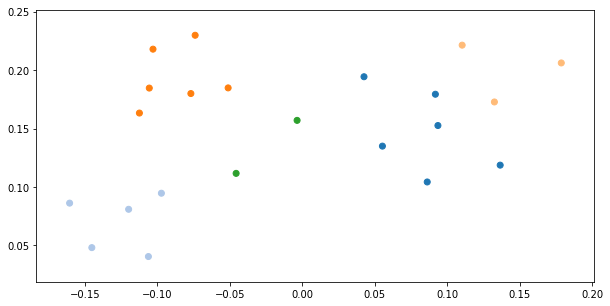

In [13]:
# Usando disimilitud diámetro y K-means como método de separacion
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_Kmeans, Dxglobal=Dx)
plot_dendrograma_de_mparticiones(mD, mParticiones)
plot_particion_K(Dx, mParticiones, K)

<hr>
<h2>Implementaciones en librerías de Python</h2>

Dada la complejidad añadida del clustering jerárquico divisivo (respecto al aglomerativo), las principales librarías de aprendizaje automático de Python <b>no implementan</b> esta versión del agrupamiento jerárquico.
